# Analysis of Gridded Ensemble Precipitation Estimates over Australia

In this notebook we work with several ensemble members of precipitation data. The analysis we do below is quite simple but the problem is a good illustration of a common task in the atmospheric sciences. 

* Open dataset
* Average seasonal precipitation
* Extract a time series of annual maximum precipitation events over a region

The following material uses Coupled Model Intercomparison Project (CMIP6) collections. The CMIP6 terms of use are found [here](https://pcmdi.llnl.gov/CMIP6/TermsOfUse/TermsOfUse6-1.html). For more information on the collection, please visit the [NCI Data Catalogue]( https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/metadata/f6600_2266_8675_3563).

---

- Authors: NCI Virtual Research Environment Team
- Keywords: CMIP6, xarray, dask, precipitation
- Creation Date: 2020-April
- Lineage/Reference: This tutorial is referenced to [Pangeo example](https://github.com/pangeo-data/pangeo-example-notebooks/blob/master/cm26.ipynb).
---

### Setup

Choose from the following two options to create a client:

In [ ]:
# If you run this notebook on your local computer or NCI's VDI instance, you can create cluster
from dask.distributed import Client
client = Client()
print(client)

In [1]:
# If you run this notebook on Gadi under pangeo environment, you can create cluster using scheduler.json file
from dask.distributed import Client, LocalCluster
client = Client(scheduler_file='scheduler.json')
print(client)

<Client: 'tcp://10.6.23.34:8726' processes=96 threads=96, memory=404.98 GB>


/apps/pangeo/2020.05/lib/python3.7/site-packages/distributed/client.py:1079: VersionMismatchWarning: Mismatched versions found

numpy
+------------------------+---------+
|                        | version |
+------------------------+---------+
| client                 | 1.19.2  |
| scheduler              | 1.19.2  |
| tcp://10.6.23.34:32997 | 1.17.2  |
| tcp://10.6.23.34:33389 | 1.17.2  |
| tcp://10.6.23.34:33485 | 1.17.2  |
| tcp://10.6.23.34:33491 | 1.17.2  |
| tcp://10.6.23.34:33711 | 1.17.2  |
| tcp://10.6.23.34:33725 | 1.17.2  |
| tcp://10.6.23.34:34877 | 1.17.2  |
| tcp://10.6.23.34:35513 | 1.17.2  |
| tcp://10.6.23.34:36165 | 1.17.2  |
| tcp://10.6.23.34:36285 | 1.17.2  |
| tcp://10.6.23.34:36447 | 1.17.2  |
| tcp://10.6.23.34:36879 | 1.17.2  |
| tcp://10.6.23.34:37195 | 1.17.2  |
| tcp://10.6.23.34:37391 | 1.17.2  |
| tcp://10.6.23.34:37753 | 1.17.2  |
| tcp://10.6.23.34:37961 | 1.17.2  |
| tcp://10.6.23.34:38063 | 1.17.2  |
| tcp://10.6.23.34:38831 | 1.17.2  |
| tcp://10.6.23

<div class="alert alert-info">
<b>Warning: Please make sure you specify the correct path to the scheduler.json file within your environment.</b>  
</div>

Starting the Dask Client will provide a dashboard which is useful to gain insight into the computation. The link to the dashboard will become visible when you create the Client. We recommend having the Client open on one side of your screen and your notebook open on the other side, which will be useful for learning purposes.

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
!ls /g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/

r1i1p1f1  r2i1p1f1  r3i1p1f1


### Open Dataset

Here we load the historical precipitation data of the ACCESS-CM2 model within the CMIP6 archive. 

The dataset has dimensions of time, latitude, longitude, and ensemble members.

In [3]:
EnsNum=3
DS=[]
for i in range(EnsNum): #loop through ensemble members
    #concatenate data on time coordinate
    data=xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r'+str(i+1)+'i1p1f1/day/pr/gn/v*/pr_day_ACCESS-CM2_historical_r'+str(i+1)+'i1p1f1_gn_*.nc',combine='nested', concat_dim='time' )
    DS.append(data)

In [4]:
ds=xr.concat([DS[i] for i in range(EnsNum)],'ensemble')

### Intra-ensemble range

We calculate the intra-ensemble range for all the mean daily temperature in this dataset.  This gives us a sense of uncertainty.

In [5]:
pr_mean = ds['pr'].mean(dim='time')
spread = (pr_mean.max(dim='ensemble')
        - pr_mean.min(dim='ensemble'))
spread

<xarray.DataArray 'pr' (lat: 144, lon: 192)>
dask.array<sub, shape=(144, 192), dtype=float32, chunksize=(144, 192), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38

### Calling compute
The expressions above didn't actually compute anything but rather just build the task graph. To do the computations, we call the `compute` or `persist` methods:

In [6]:
spread = spread.persist()

In [7]:
spread.load

<bound method DataArray.load of <xarray.DataArray 'pr' (lat: 144, lon: 192)>
dask.array<sub, shape=(144, 192), dtype=float32, chunksize=(144, 192), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38>

#### Figure: Intra-ensemble range


Text(0.5, 1.0, 'Intra-ensemble range in mean annual precipitation')

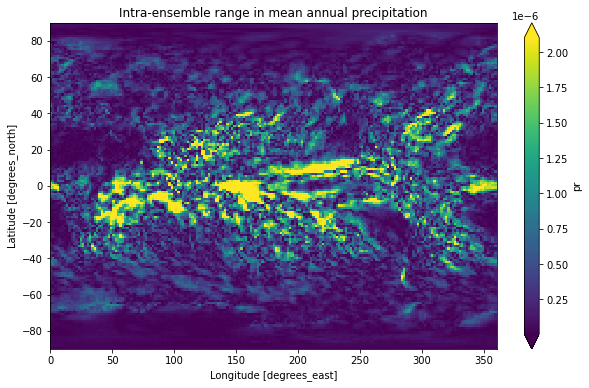

In [8]:
spread.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in mean annual precipitation')

### Average seasonal precipitation

We can compute a crude estimate of average seasonal precipitation variables in our dataset. Here, we'll look at the first 2 ensemble members and make some maps of the seasonal total precipitation in each ensemble member.

In [9]:
da_pr = ds['pr'].resample(time='QS-MAR').sum('time')
seasonal_pr = da_pr.isel(ensemble=slice(0, 2)).groupby('time.season').mean('time').persist()
#progress(seasonal_pr)

/g/data/dk92/packages/xarray/core/common.py:1124: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset


In [10]:
# properly sort the seasons
seasonal_pr = seasonal_pr.sel(season=['DJF', 'MAM','JJA', 'SON'])
seasonal_pr

<xarray.DataArray 'pr' (ensemble: 2, season: 4, lat: 144, lon: 192)>
dask.array<getitem, shape=(2, 4, 144, 192), dtype=float32, chunksize=(1, 1, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
Dimensions without coordinates: ensemble

#### Figure: Average seasonal precipitation totals 

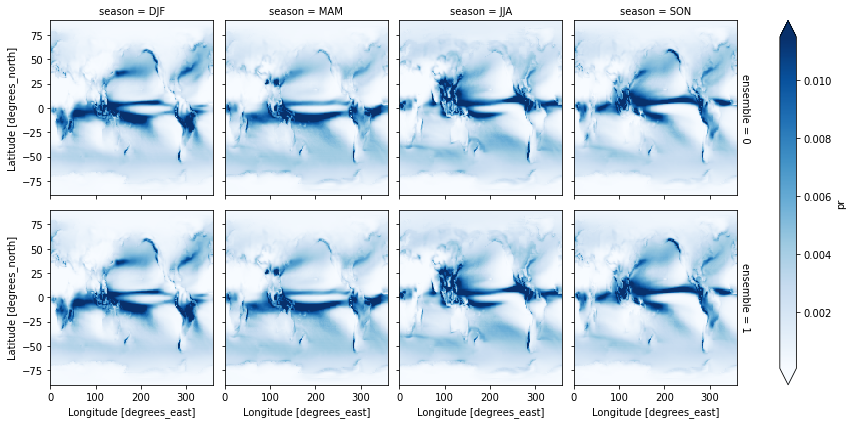

In [11]:
seasonal_pr.plot.pcolormesh(col='season', row='ensemble', cmap='Blues', robust=True)

### Extract a time series of annual maximum precipitation events over a region

In the previous two examples, we've mostly reduced the time and/or ensemble dimension. Here, we'll do a reduction operation on the spatial dimension to look at a time series of extreme precipitation events near Sydney, AU (33.51° S, 151.12° E).

In [12]:
buf = 0.25  # look at Sydney +/- 0.25 deg

ds_tx = ds.sel(lon=slice(151.12-buf, 151.12+buf), lat=slice(-33.51-buf, 33.51+buf))

In [13]:
pcp_ann_max = ds_tx['pr'].resample(time='AS').max('time')

/g/data/dk92/packages/xarray/core/common.py:1124: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset


In [14]:
pcp_ann_max_ts = pcp_ann_max.max(('lat', 'lon')).persist()
#progress(pcp_ann_max_ts)

#### Figure: Timeseries of maximum precipitation near Sydney, AU.

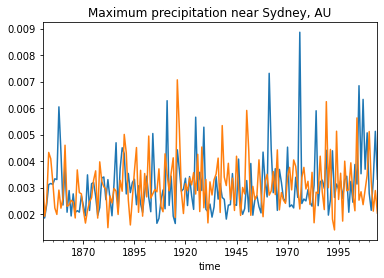

In [15]:
ax = pcp_ann_max_ts.transpose().to_pandas().plot(title='Maximum precipitation near Sydney, AU', legend=False)

### Close the client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [ ]:
client.close()

## Reference

This example is modified from https://github.com/pangeo-data/pangeo-example-notebooks/blob/master/xarray-data.ipynb